In [1]:
import pandas as pd
import numpy as np
import sqlalchemy
from sqlalchemy import create_engine
from flask_sqlalchemy import SQLAlchemy

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import classification_report

from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import cross_val_predict
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import warnings
import os
%matplotlib inline

warnings.filterwarnings("ignore") #, category=DeprecationWarning)

/Users/brianmcmahon/anaconda3/envs/tensorflow1.4/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
# env variable at tensorflow1.4 per https://conda.io/docs/user-guide/tasks/manage-environments.html#saving-environment-variables
# and https://vsupalov.com/flask-sqlalchemy-postgres/

def get_env_variable(name):
    try:
        return os.environ[name]
    except KeyError:
        message = "Expected environment variable '{}' not set.".format(name)
        raise Exception(message)

# the values of those depend on your setup
POSTGRES_URL = get_env_variable("POSTGRES_URL")
POSTGRES_USER = get_env_variable("POSTGRES_USER")
POSTGRES_PW = get_env_variable("POSTGRES_PW")
POSTGRES_DB = get_env_variable("POSTGRES_DB")

In [3]:
DB_URL = 'postgresql+psycopg2://{user}:{pw}@{url}/{db}'.format(user=POSTGRES_USER,pw=POSTGRES_PW,url=POSTGRES_URL,db=POSTGRES_DB)

In [4]:
engine_var = DB_URL
engine = create_engine(engine_var)

In [7]:
# df = pd.read_pickle('data/kickstarter_data.pkl')
# TODO determine whie ID shows up but is not called - index issue?
df = pd.read_sql_query('''SELECT main_category, currency, deadline, usd_goal_real, usd_pledged_real, launched, state, country
                        FROM kickstarter_data''',engine)
pd.read_sql_query('''SELECT * FROM kickstarter_data LIMIT 5''',engine)

,index,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real,campaign_length,pct_goal_achieved
0,6201,1031685482,You Sparkle Inside: A Kids' Book + Commissions...,Children's Books,Publishing,USD,2018-01-02,2000.0,2017-12-06,6083.00,successful,133,US,1054.0,6083.00,2000.0,27,304.150000
1,34850,1176736360,THE NEW BILLY WYLDER RECORD,Indie Rock,Music,USD,2018-01-02,10000.0,2017-11-30,11169.56,successful,177,US,650.0,11169.56,10000.0,33,111.695600
2,175913,1894703097,Driftwood Holly ***The Venice Project***,Indie Rock,Music,EUR,2018-01-02,25000.0,2017-11-28,25417.20,successful,168,DE,0.0,30615.02,30112.5,35,101.668809
3,244176,311863059,On a Limb's debut album,Jazz,Music,USD,2018-01-02,1000.0,2017-12-09,1743.00,successful,39,US,0.0,1743.00,1000.0,24,174.300000
4,211145,2076121120,Briggs Barbecue Sauces,Small Batch,Food,USD,2018-01-02,200000.0,2017-11-03,1.00,failed,1,US,0.0,1.00,200000.0,60,0.000500


In [8]:
pd.read_sql_query('''SELECT count(name), SUM(usd_pledged_real) as USD_Pledged,SUM(usd_goal_real) as USD_Goal FROM kickstarter_data''',engine)

,count,usd_pledged,usd_goal
0,19291,2.627727e+08,8.743479e+08


In [9]:
pd.read_sql_query('''SELECT state,COUNT(state) as count, SUM(usd_goal_real) as usd_goal, SUM(usd_pledged_real) as usd_pledged FROM kickstarter_data GROUP BY state ORDER BY usd_pledged DESC LIMIT 10''',engine)

,state,count,usd_goal,usd_pledged
0,successful,8368,8.123888e+07,2.493829e+08
1,failed,10923,7.931090e+08,1.338983e+07


In [10]:
pd.read_sql_query('''SELECT main_category,COUNT(main_category) as count, SUM(usd_goal_real) as usd_goal,SUM(usd_pledged_real) as usd_pledged FROM kickstarter_data Group By main_category ORDER BY usd_pledged DESC LIMIT 5''',engine)

,main_category,count,usd_goal,usd_pledged
0,Games,2541,4.814846e+07,70608172.84
1,Design,2127,5.219732e+07,66428025.84
2,Technology,2081,1.065280e+08,56029162.80
3,Film & Video,1943,3.962250e+08,13787683.40
4,Publishing,2005,2.271882e+07,10911971.51


In [11]:
pd.read_sql_query('''SELECT country, COUNT(country) as count,SUM(usd_goal_real) as usd_goal,SUM(usd_pledged_real)  as usd_pledged FROM kickstarter_data GROUP BY country ORDER BY usd_pledged DESC LIMIT 5''',engine)

,country,count,usd_goal,usd_pledged
0,US,12204,6.723174e+08,1.872663e+08
1,GB,2207,4.608401e+07,1.871978e+07
2,CA,962,3.122999e+07,7.231933e+06
3,DE,519,1.847728e+07,6.270310e+06
4,NL,216,4.211652e+06,5.824917e+06


In [12]:
pd.read_sql_query('''SELECT currency,COUNT(currency) as count,SUM(usd_goal_real) as usd_goal,SUM(usd_pledged_real) as usd_pledged FROM kickstarter_data GROUP BY currency ORDER BY usd_pledged DESC LIMIT 5''',engine)

,currency,count,usd_goal,usd_pledged
0,USD,12204,6.723174e+08,1.872663e+08
1,EUR,1941,7.315434e+07,2.764281e+07
2,GBP,2207,4.608401e+07,1.871978e+07
3,CAD,962,3.122999e+07,7.231933e+06
4,AUD,581,1.419635e+07,5.774700e+06


In [13]:
# Prep for categorical analysis
df.main_category = pd.Categorical(df.main_category) 
df['main_category_code'] = df.main_category.cat.codes

df.country = pd.Categorical(df.country) 
df['country_code'] = df.country.cat.codes

df.currency = pd.Categorical(df.currency) 
df['currency_code'] = df.currency.cat.codes

df.state = pd.Categorical(df.state) 
df['state_code'] = df.state.cat.codes

df.head(100)

,main_category,currency,deadline,usd_goal_real,usd_pledged_real,launched,state,country,main_category_code,country_code,currency_code,state_code
0,Publishing,USD,2018-01-02,2000.00,6083.00,2017-12-06,successful,US,12,21,13,1
1,Music,USD,2018-01-02,10000.00,11169.56,2017-11-30,successful,US,10,21,13,1
2,Music,EUR,2018-01-02,30112.50,30615.02,2017-11-28,successful,DE,10,5,4,1
3,Music,USD,2018-01-02,1000.00,1743.00,2017-12-09,successful,US,10,21,13,1
4,Food,USD,2018-01-02,200000.00,1.00,2017-11-03,failed,US,7,21,13,0
5,Crafts,USD,2018-01-02,380.00,54.00,2017-11-13,failed,US,2,21,13,0
6,Games,GBP,2018-01-02,5420.64,0.00,2017-12-08,failed,GB,8,9,5,0
7,Music,USD,2018-01-02,80000.00,156961.09,2017-11-17,successful,US,10,21,13,1
8,Design,MXN,2018-01-02,1549.03,219.45,2017-11-18,failed,MX,4,15,8,0
9,Technology,USD,2018-01-02,10000.00,0.00,2017-11-23,failed,US,13,21,13,0


In [14]:
X = df[['main_category_code','country_code','currency_code','usd_goal_real']]
y = df['state_code']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.7,random_state=42)

k_range = list(range(1, 101))
print(X.shape)
print(y.shape)

(19291, 4)
(19291,)


## Classification
See Challenges 7 and 8.

In [15]:
k_acc = []

for k in k_range:
    knn = KNeighborsClassifier(k)
    knn.fit(X_train, y_train)
    knn_prediction = knn.predict(X_test)
    k_acc.append(accuracy_score(y_test, knn_prediction))

Text(0.5,1,'knn model - accuracy vs neighbors')

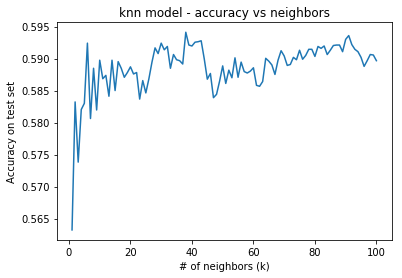

In [16]:
plt.plot(k_range, k_acc)
plt.xlabel('# of neighbors (k)')
plt.ylabel('Accuracy on test set')
plt.title('knn model - accuracy vs neighbors')

In [17]:
## Make a logistic regression object, fit it on the training set, and test it to find accuracy
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)
logistic_prediction = log_reg.predict(X_test)
log_reg_accuracy = accuracy_score(y_test, logistic_prediction)
print(log_reg_accuracy)

0.5633145734597157


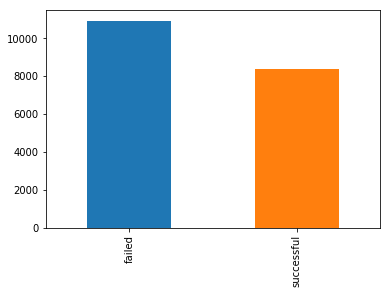

In [18]:
df.state.value_counts().plot(kind = 'bar')

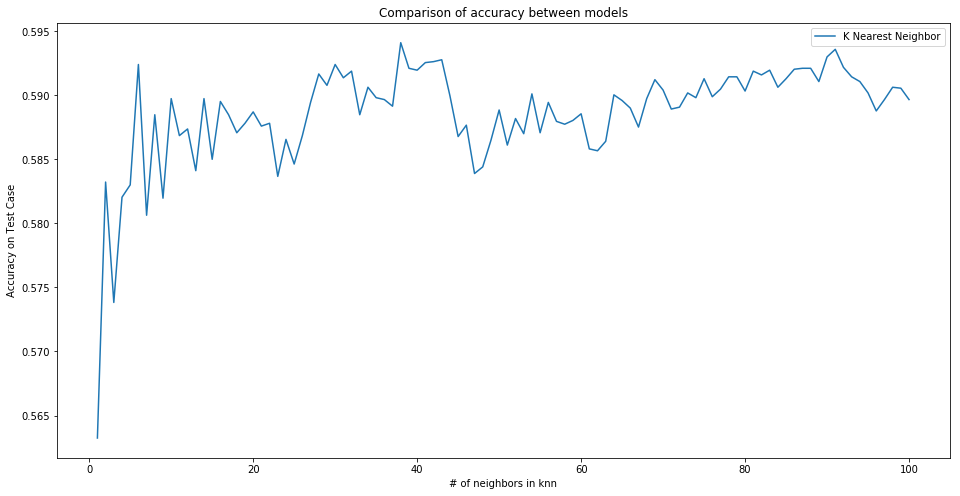

In [19]:
plt.figure(figsize=(16,8))
plt.plot(k_range, k_acc, '-', label = 'K Nearest Neighbor')
# plt.plot(k_range, [log_reg_accuracy]*len(k_range), '-', label = 'Logistic Regression')
# plt.plot(n_neighbors, [dem_acc]*20, '-', label = 'Predict All Democrats')
# plt.plot(n_neighbors, [rep_acc]*20, '-', label = 'Predict All Republicans')
plt.title('Comparison of accuracy between models')
plt.xlabel('# of neighbors in knn')
plt.ylabel('Accuracy on Test Case')
plt.legend(loc = 0)

In [20]:
# TO DO get top 5 k values
best_k = k_range[np.argmax(k_acc)]
best_k

38

In [21]:
from sklearn.learning_curve import learning_curve

In [22]:
[m, train_score, test_score] = learning_curve(log_reg, X, y)

In [23]:
train_cv_err = np.mean(train_score, axis=1)
test_cv_err = np.mean(test_score, axis=1)

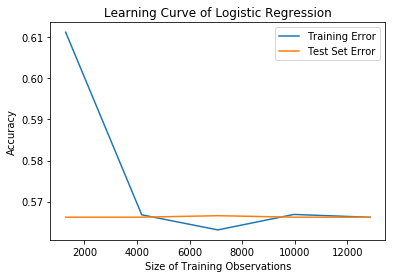

In [24]:
plt.plot(m, train_cv_err, label='Training Error')
plt.plot(m, test_cv_err, label = 'Test Set Error')
plt.title('Learning Curve of Logistic Regression')
plt.xlabel('Size of Training Observations')
plt.ylabel('Accuracy')
plt.legend(loc=0)

In [25]:
[m2, train_score2, test_score2] = learning_curve(KNeighborsClassifier(best_k), X,y)

In [26]:
train_cv_err2 = np.mean(train_score2, axis=1)
test_cv_err2 = np.mean(test_score2, axis=1)

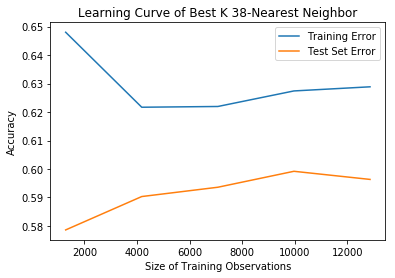

In [27]:
plt.plot(m2, train_cv_err2, label='Training Error')
plt.plot(m2, test_cv_err2, label = 'Test Set Error')
plt.title('Learning Curve of Best K {}-Nearest Neighbor'.format(best_k))
plt.xlabel('Size of Training Observations')
plt.ylabel('Accuracy')
plt.legend(loc=0)

In [28]:
train_sizes, train_scores, test_scores = learning_curve(LogisticRegression(), 
                                                        X, y,
                                                        cv=10, 
                                                        scoring='accuracy')

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

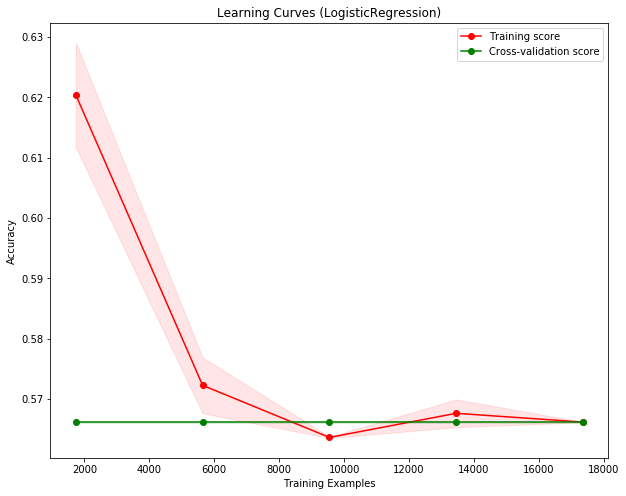

In [29]:
# Plot Training Examples vs. Accuracy
fig, ax = plt.subplots(figsize=(10, 8))

plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

ax.set_title('Learning Curves (LogisticRegression)')
ax.set_xlabel('Training Examples')
ax.set_ylabel('Accuracy')
ax.legend(loc='best');

In [30]:
k = 4
train_sizes, train_scores, test_scores = learning_curve(KNeighborsClassifier(k), 
                                                        X, y, 
                                                        train_sizes=np.linspace(0.05, 0.95, 18),
                                                        cv=10, 
                                                        scoring='accuracy')

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

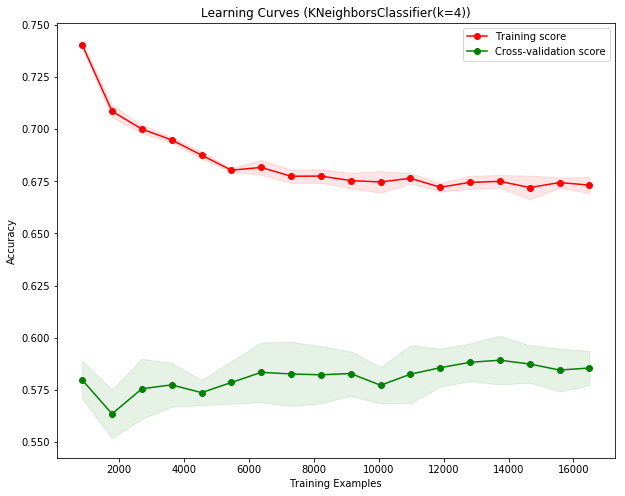

In [31]:
# Plot Training Examples vs. Accuracy
fig, ax = plt.subplots(figsize=(10, 8))

plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

# ax.plot(train_sizes, train_scores_mean, lw=2, color='r', label='Training Score')
# ax.plot(train_sizes, test_scores_mean, lw=2, color='g', label='CV Score')

ax.set_title('Learning Curves (KNeighborsClassifier(k=%d))' % k)
ax.set_xlabel('Training Examples')
ax.set_ylabel('Accuracy')
# ax.set_ylim([0, 1]);
ax.legend(loc='best');

In [32]:
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

In [33]:
model_list = [GaussianNB(), SVC(), DecisionTreeClassifier(), RandomForestClassifier()]
for model in model_list:
    train_sizes, train_scores, test_scores = learning_curve(model, 
                                                            X, y, 
                                                            train_sizes=[0.7],
                                                            cv=10, 
                                                            scoring='accuracy')

    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    print('%s:\n\tTest Score: Mean= %.3f, Std= %.3f\n' % (model, test_scores_mean, test_scores_std))

GaussianNB(priors=None):
	Test Score: Mean= 0.468, Std= 0.006

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False):
	Test Score: Mean= 0.593, Std= 0.011

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'):
	Test Score: Mean= 0.591, Std= 0.012

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weigh

In [34]:
from sklearn.model_selection import cross_val_score

model_list = [GaussianNB(), SVC(), DecisionTreeClassifier(), RandomForestClassifier()]
for model in model_list:
    test_scores = cross_val_score(model, X, y=y, cv=10, scoring='accuracy')
    test_scores_mean = np.mean(test_scores)
    test_scores_std = np.std(test_scores)
    
    print('%s:\n\tTest Score: Mean= %.3f, Std= %.3f\n' % (model, test_scores_mean, test_scores_std))

GaussianNB(priors=None):
	Test Score: Mean= 0.469, Std= 0.006

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False):
	Test Score: Mean= 0.599, Std= 0.010

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'):
	Test Score: Mean= 0.598, Std= 0.014

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weigh

In [35]:
logreg = LogisticRegression()
log_accuracy = cross_val_score(logreg, X, y, cv=10, scoring='accuracy').mean()
log_accuracy

0.5662225928643035

In [36]:
kval = np.arange(1, 101)
accuracy = np.zeros(kval.shape)
for idx, k in enumerate(kval):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    accuracy[idx] = accuracy_score(y_test, y_pred)

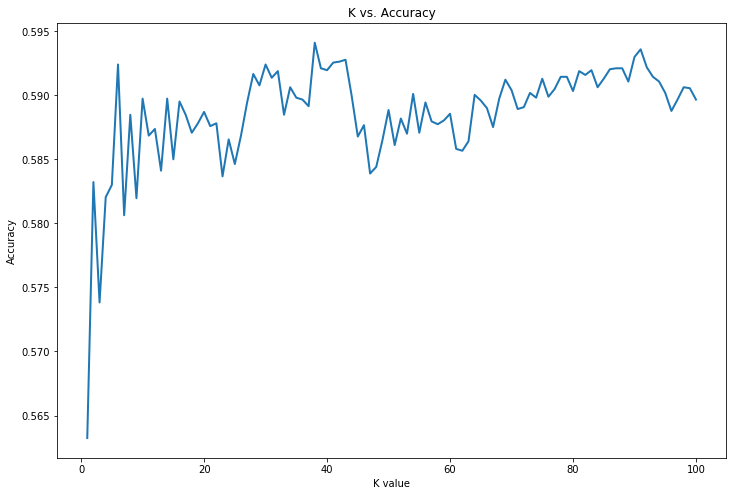

In [37]:
# Plot K vs. Accuracy
fig = plt.figure(figsize=(12, 8))
plt.plot(kval, accuracy, lw=2)
# plt.ylim([0, 1]);
plt.title('K vs. Accuracy')
plt.xlabel('K value')
plt.ylabel('Accuracy');

In [38]:
# argmax finds first occurence of max
best_k = kval[np.argmax(accuracy)]
best_k

38

In [39]:
# but for KNN, a larger K is generally better since it's a less complex model
# (i.e., less likely to overfit)
best_k = max(kval[accuracy == max(accuracy)])
best_k

38

In [40]:
knn = KNeighborsClassifier(n_neighbors=best_k)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
accuracy_score(y_test, y_pred)

0.5941202606635071

In [41]:
train_sizes, train_scores, test_scores = learning_curve(LogisticRegression(), 
                                                        X, y,
                                                        cv=10, 
                                                        scoring='accuracy')

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

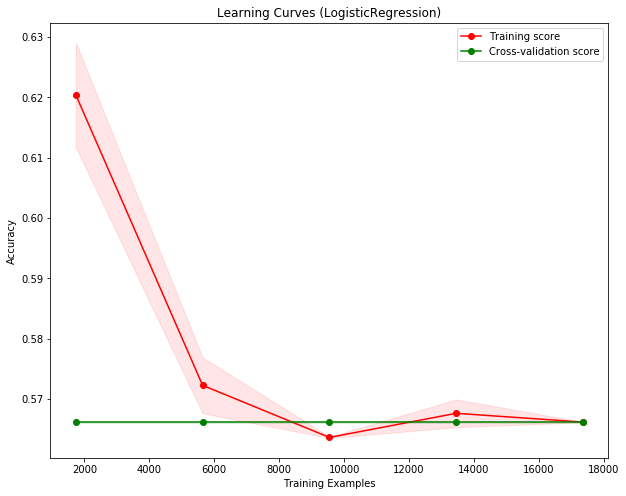

In [42]:

# Plot Training Examples vs. Accuracy
fig, ax = plt.subplots(figsize=(10, 8))

plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

ax.set_title('Learning Curves (LogisticRegression)')
ax.set_xlabel('Training Examples')
ax.set_ylabel('Accuracy')
ax.legend(loc='best');

## Classification Errors
See Challenge 8.

In [43]:
# Define models to test
model_list = [['KNN', KNeighborsClassifier(9)], # K=9 was best performance from Challenge07
              ['Logistic', LogisticRegression()],
              ['GaussianNB', GaussianNB()], 
              ['SVC', SVC(probability=True)], 
              ['DecisionTree', DecisionTreeClassifier()], 
              ['RandomForest', RandomForestClassifier()]]

# Calculate metrics for each model
roc = {}
for model in model_list:
    
    model_name = model[0]
    model = model[1]
    
    accuracy = []
    precision = []
    recall = []
    f1 = []
    auc = []
        
    # Perform K-Fold CV and calculate metrics for each fold
    kf = KFold(5, random_state=4444, shuffle=True)
    for train_idx, test_idx in kf.split(X, y=y):
        X_train = X.iloc[train_idx, :] 
        X_test = X.iloc[test_idx, :] 
        y_train = y.iloc[train_idx] 
        y_test = y.iloc[test_idx] 
        
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        accuracy.append(accuracy_score(y_test, y_pred))
        precision.append(precision_score(y_test, y_pred))
        recall.append(recall_score(y_test, y_pred))
        f1.append(f1_score(y_test, y_pred))
        auc.append(roc_auc_score(y_test, y_pred))
        
    
    # Calculate mean metric across K-folds
    mean_accuracy = np.mean(accuracy)
    mean_precision = np.mean(precision)
    mean_recall = np.mean(recall)
    mean_f1 = np.mean(f1)
    mean_auc = np.mean(auc)
    
    # Capture TPR and FPR from last fold for plotting
    y_score = model.predict_proba(X_test)[:,1]
    roc[model_name] = roc_curve(y_test, y_score)
    
    # Print formatted results
    print(model)
    print('\t==============================')
    print('\tAccuracy:', mean_accuracy)
    print('\tPrecision:', mean_precision)
    print('\tRecall:', mean_recall)
    print('\tF1:', mean_f1)
    print('\tAUC:', mean_auc)
    print('\n')

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=9, p=2,
           weights='uniform')
	Accuracy: 0.5890316524250166
	Precision: 0.5305551209359607
	Recall: 0.45905854236632476
	F1: 0.4921325459786724
	AUC: 0.5738550799208825


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
	Accuracy: 0.5662231020346423
	Precision: 0.0
	Recall: 0.0
	F1: 0.0
	AUC: 0.5


GaussianNB(priors=None)
	Accuracy: 0.46907841753592255
	Precision: 0.44886224082384685
	Recall: 0.9829260469759111
	F1: 0.6162639702854162
	AUC: 0.5291727142594583


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shri

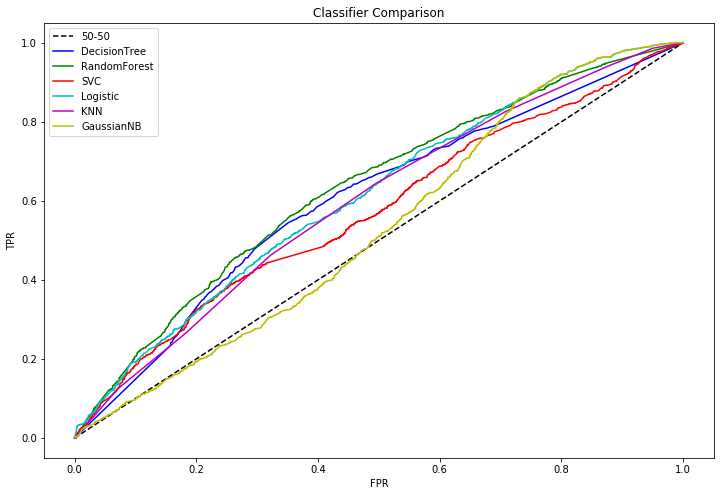

In [44]:
# Plot the ROC curve from the last K-Fold split
fig, ax = plt.subplots(figsize=(12, 8))
colors = ['b', 'g', 'r', 'c', 'm', 'y']

# Plot 50-50 Line
ax.plot([0,1],[0,1], ls='--', color='k', label='50-50')
# Plot Classifier ROC Curves
for key, c in zip(roc.keys(), colors):
    ax.plot(roc[key][0], roc[key][1], color=c, label=key)
    
ax.set_xlabel('FPR')
ax.set_ylabel('TPR')
ax.set_title('Classifier Comparison')
ax.legend(loc='best');

In [45]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)

In [46]:
# Find the weighted precision and recall
print('Weighted Precision:', precision_score(y_test, y_pred, average='weighted'))
print('Weighted Recall:', recall_score(y_test, y_pred, average='weighted'))

Weighted Precision: 0.3317138940420168
Weighted Recall: 0.5759460860549508


In [47]:
print(classification_report(y_test, y_pred)) #, target_names=target_names))

             precision    recall  f1-score   support

          0       0.58      1.00      0.73      2222
          1       0.00      0.00      0.00      1636

avg / total       0.33      0.58      0.42      3858



In [48]:
logreg = OneVsRestClassifier(LogisticRegression())
logreg.fit(X_train, y_train)
y_score = logreg.decision_function(X_test)

In [49]:
print('Micro Average Precision:', average_precision_score(y_test, y_score, average='micro'))
print('Macro Average Precision:', average_precision_score(y_test, y_score, average='macro'))
print('Weighted Average Precision:', average_precision_score(y_test, y_score, average='weighted'))
print('Precision for each Class:', average_precision_score(y_test, y_score, average=None))

Micro Average Precision: 0.5279701118514407
Macro Average Precision: 0.5279701118514407
Weighted Average Precision: 0.5279701118514407
Precision for each Class: 0.5279701118514407


In [50]:
precision, recall, _ = precision_recall_curve(y_test.ravel(), y_score.ravel())

In [51]:
precision

array([0.42838439, 0.42834687, 0.42845912, ..., 1.        , 1.        ,
       1.        ])

In [52]:
recall

array([1.00000000e+00, 9.99388753e-01, 9.99388753e-01, ...,
       1.22249389e-03, 6.11246944e-04, 0.00000000e+00])

In [53]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
accuracy_score(y_test, y_pred)

0.5759460860549508

In [54]:
from sklearn.metrics import roc_curve, auc

y_score = logreg.predict_proba(X_test)[:,1]
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

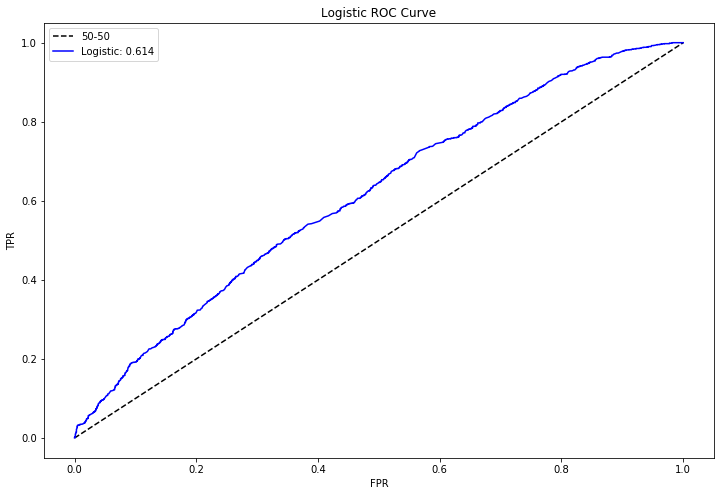

In [55]:
fig, ax = plt.subplots(figsize=(12, 8))

# Plot 50-50 Line
ax.plot([0,1],[0,1], ls='--', color='k', label='50-50')
# Plot Logistic ROC curve
ax.plot(fpr, tpr, color='b', label='Logistic: %.3f' % roc_auc)
    
ax.set_xlabel('FPR')
ax.set_ylabel('TPR')
ax.set_title('Logistic ROC Curve')
ax.legend(loc='best');